In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
train_link = 'https://drive.google.com/open?id=1wvniXEx4IcuKzJRbFIeGxDkM_O-G_h6q'
test_link = 'https://drive.google.com/open?id=1_7PMewTe3yiPNB_FJDi_wE3LBg6FWtCR'

In [0]:
fluff_train, id_train = train_link.split('=')
fluff_test, id_test = test_link.split('=')

In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id_train}) 
downloaded.GetContentFile('train.csv')  
train_df = pd.read_csv('train.csv')

downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test.csv')  
test_df = pd.read_csv('test.csv')

In [0]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [0]:
print(train_df[train_df.comment_text.isnull()]) #No entry where comment is empty
print(train_df[train_df.comment_text == '']) #No entry where comment length is 0

Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate]
Index: []
Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate]
Index: []


In [0]:
print(train_df.shape)
print(test_df.shape)
print(train_df.toxic.value_counts()) #Total count of the Toxic entries

(159571, 8)
(153164, 2)
0    144277
1     15294
Name: toxic, dtype: int64


In [0]:
#All severe toxic are Toxic, but not other way around
pd.crosstab(train_df.toxic, train_df.severe_toxic)


severe_toxic,0,1
toxic,,
0,144277,0
1,13699,1595


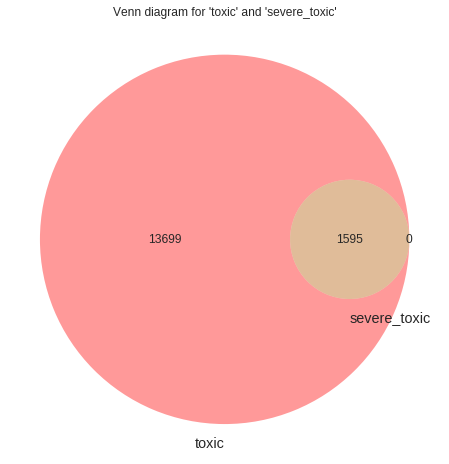

In [0]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
toxic_comm = train_df[(train_df['toxic'] == 1) & (train_df['severe_toxic'] == 0)].shape[0]
severe_comment = train_df[(train_df['toxic'] == 0) & (train_df['severe_toxic'] == 1)].shape[0]
toxic_severe = train_df[(train_df['toxic'] == 1) & (train_df['severe_toxic'] == 1)].shape[0]

# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'severe_toxic'")
venn2(subsets = (toxic_comm, severe_comment, toxic_severe), set_labels=('toxic', 'severe_toxic'))
plt.show()

In [0]:
#Relation between Toxic and other comment type , Can draw venn diagram as well
pd.crosstab(train_df.toxic, [train_df.obscene, train_df.threat, train_df.insult, train_df.identity_hate])

obscene             0                                    1                     \
threat              0                    1               0                  1   
insult              0          1         0      1        0         1        0   
identity_hate       0    1     0    1    0  1   0  1     0   1     0    1   0   
toxic                                                                           
0              143346   54   301   28   22  0   3  0   317   3   181   18   2   
1                5707  139  1229  141  124  8  17  3  1916  41  4789  883  15   

obscene                 
threat                  
insult           1      
identity_hate    0   1  
toxic                   
0                2   0  
1              195  87

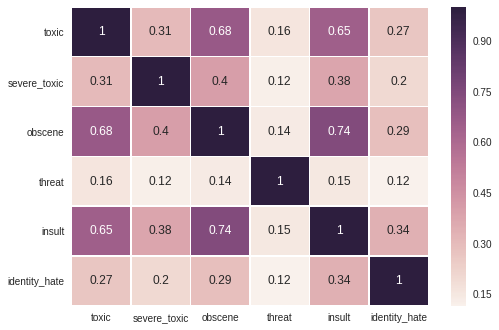

In [0]:
import seaborn as sns
sns.heatmap(train_df.iloc[:, 2:8].corr(), annot=True, linewidths=.5)  #correlations for severe_toxic are always smaller than for toxic
#Few intresting comment type combination
#'toxic' <-> 'severe_toxic'
#'toxic' <-> 'insult' and 'toxic' <-> 'obscene'
#'insult' <-> 'obscene

In [0]:
#Identify how many comment are without any of the tag
comment_type = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df['none'] = (train_df[comment_type].max(axis=1) == 0).astype(int)
comment_type.append('none')
print(train_df.none.value_counts()) #1443346 comments are not tagged with any of the comment type

1    143346
0     16225
Name: none, dtype: int64


In [0]:
#Look at the distribution of the comment_type
comment_distribution = train_df[comment_type].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')
print(comment_distribution) #Top three are Toxic, Insult and Obscene

                count
threat            478
identity_hate    1405
severe_toxic     1595
insult           7877
obscene          8449
toxic           15294
none           143346


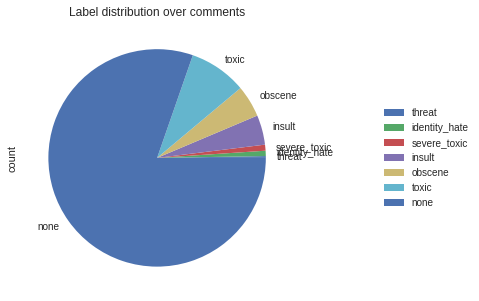

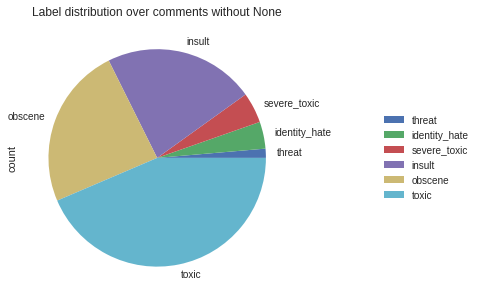

In [0]:
#Plot the distribution
comment_distribution.plot.pie(y='count',title='Label distribution over comments',figsize=(5, 5)).legend(loc='center left', bbox_to_anchor=(1.3, 0.5))
comment_distribution.drop('none').plot.pie(y='count',title='Label distribution over comments without None',figsize=(5, 5)).legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [0]:
train_df.groupby(comment_type).size().sort_values(ascending=False).reset_index().head(11) #Most commonly appearing combination, Similar to correlation plot between parameter

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,0
0,0,0,0,0,0,0,1,143346
1,1,0,0,0,0,0,0,5666
2,1,0,1,0,1,0,0,3800
3,1,0,1,0,0,0,0,1758
4,1,0,0,0,1,0,0,1215
5,1,1,1,0,1,0,0,989
6,1,0,1,0,1,1,0,618
7,0,0,1,0,0,0,0,317
8,0,0,0,0,1,0,0,301
9,1,1,1,0,1,1,0,265


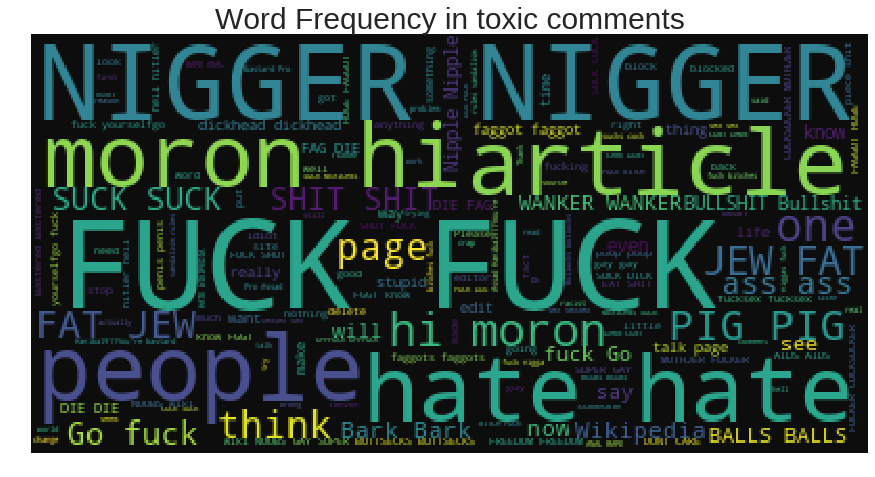

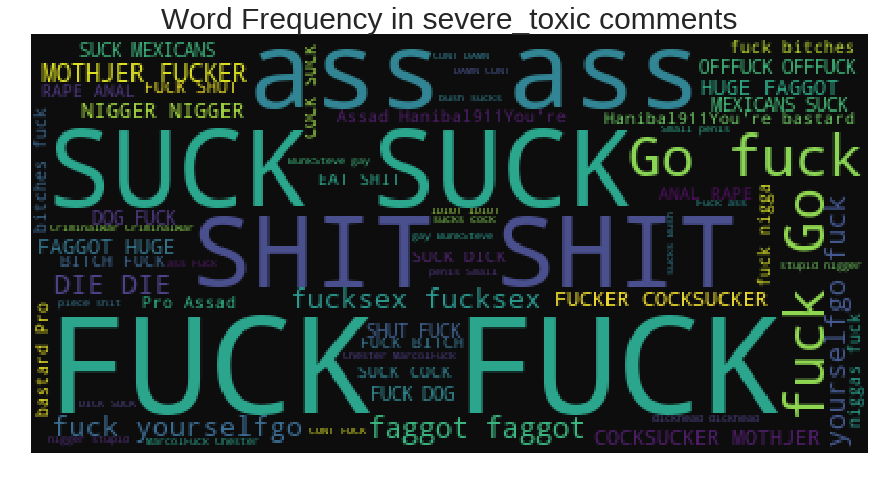

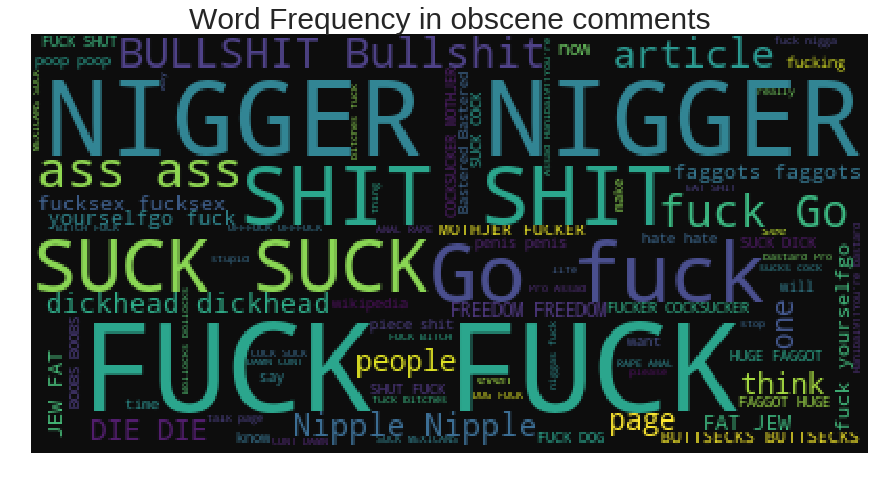

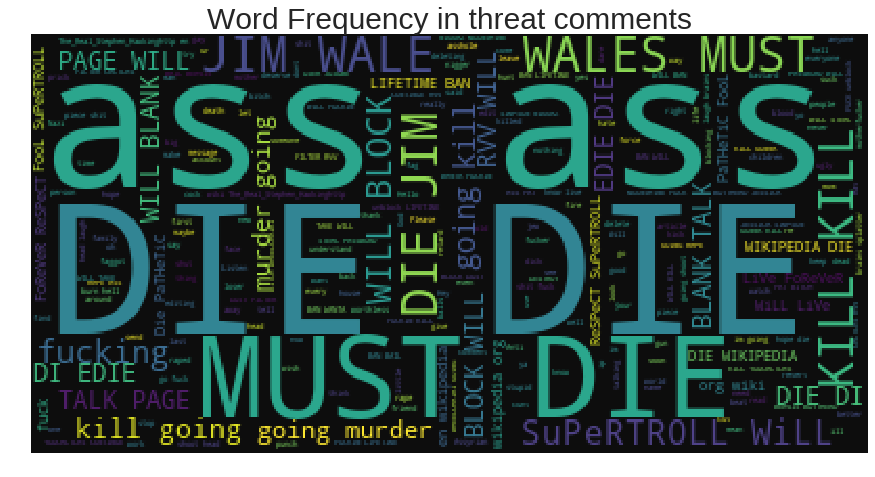

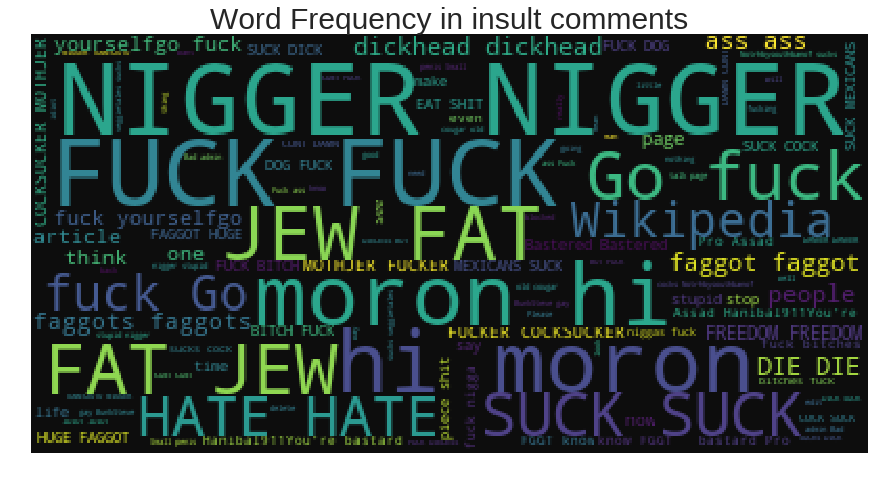

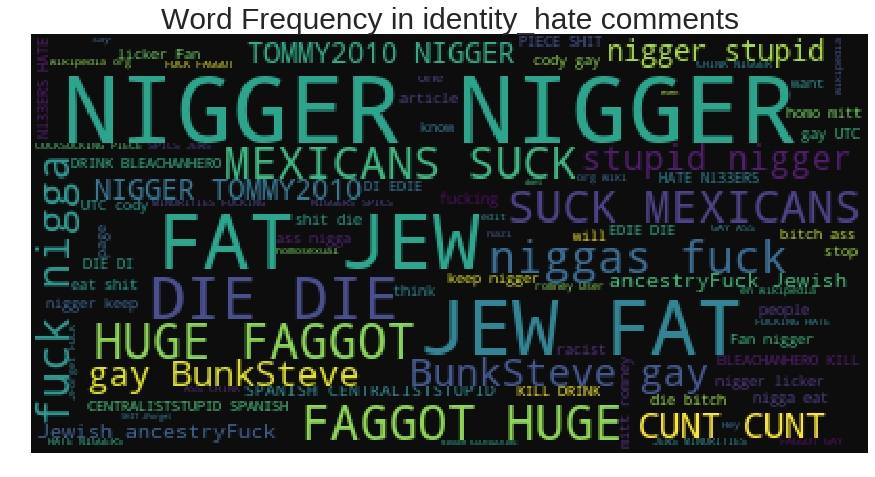

In [0]:
from PIL import Image
from wordcloud import WordCloud ,STOPWORDS
import matplotlib.pyplot as plt

stopword = set(STOPWORDS)
col = [2,3,4,5,6,7]
for elem in col:
  subset = train_df[train_df.iloc[:,elem] == 1]
  text = subset.comment_text.values
  wc = WordCloud(background_color = "black", max_words =1000, stopwords = stopword)
  wc.generate(" ".join(text))
  plt.figure(figsize = (15,15))
  plt.axis("off")
  plt.title('Word Frequency in ' + train_df.columns[elem] + ' comments', fontsize = 30)
  plt.imshow(wc.recolor(colormap = 'viridis', random_state = 10), alpha = 0.95)
  plt.show()